# Retrieval 5: Timeseries with auxiliary data

:::{admonition} About this retrieval example
This example shows how to use the [rt1 python package](https://github.com/raphaelquast/rt1_model) together with [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) to setup a retrieval procedure to 

- obtain both static and dynamic parameters from a series of incidence-angle dependent $\sigma^0$ measurements.
- use auxiliary timeseries of (incidence-angle dependent) parameter values as input
:::

In [1]:
%matplotlib widget
from rt1_model import RT1, surface, volume, set_loglevel
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import numpy as np

set_loglevel("info")

## Specify simulation and fit parameters
### Set parameter values that are used to simulate the data

In [2]:
dB, sig0 = True, True

num = 100  # Number of measurements
incs = 30  # Available incidence angles per measurement
noise_sigma = 0.5 if dB is True else 1e-3  # Noise-level (sigma of gaussian noise)

inc = np.random.normal(45, 10, (num, incs)).clip(20, 70)  # Incidence angles
N = np.random.normal(0.25, 0.25, (num, 1)).clip(0.01, 0.5)  # NormBRDF values

tau = 1.5 * np.sin(np.linspace(0, 2.*np.pi, num))**2
tau = tau[:,np.newaxis] # broadcast the tau-values among all incidence-angles

bsf = np.cos(np.linspace(0, 2.*np.pi, num))**2
# broadcast the tau-values among all incidence-angles
bsf = np.tile(bsf[:,np.newaxis], incs)* np.linspace(0.3, 1, incs)

sim_params = dict(omega=0.1, N=N)  # Simulation parameter values
const_params = dict(t_s=0.4, tau=tau, bsf=bsf)  # Constant parameters (assumed to be known)

### Visualize used auxiliary datasets

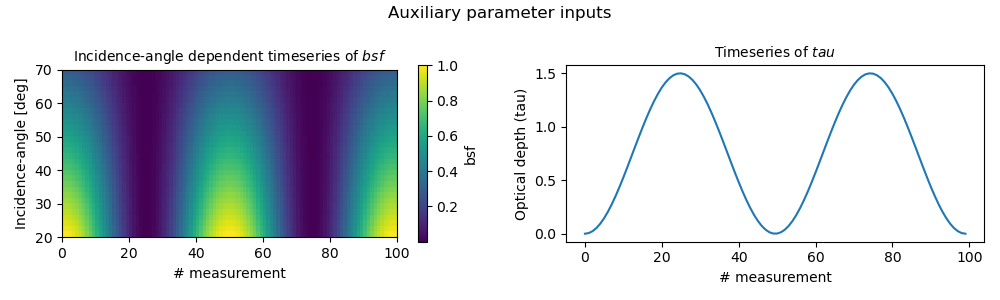

In [3]:
f, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 3))
f.canvas.header_visible = False
im = ax.imshow(bsf.T, extent=[0, num, inc.min(),inc.max()])
plt.colorbar(im, label="bsf")
ax.set_title("Incidence-angle dependent timeseries of $bsf$", fontsize="medium")
ax.set_xlabel("# measurement")
ax.set_ylabel("Incidence-angle [deg]")


ax2.plot(tau)
ax2.set_title("Timeseries of $tau$", fontsize="medium")
ax2.set_xlabel("# measurement")
ax2.set_ylabel("Optical depth (tau)")

f.suptitle("Auxiliary parameter inputs")
f.tight_layout()

### Set start values and boundaries for the fit

In [4]:
start_vals = dict(omega=0.2, N=[0.3] * num)
bnd_vals = dict(omega=(0.01, 0.5), N=[(0.01, 0.5)] * num)

## Setup RT1 and create a simulated dataset

In [5]:
V = volume.Isotropic()
SRF = surface.HG_nadirnorm(t="t_s", ncoefs=10)

R = RT1(V=V, SRF=SRF, int_Q=True, dB=dB, sig0=True)
R.set_monostatic(p_0=0)
R.NormBRDF = "N"  # Use a synonym for NormBRDF parameter

R.set_geometry(t_0=np.deg2rad(inc))
R.update_params(**sim_params, **const_params)

tot = R.calc()[0]
tot += np.random.normal(0, noise_sigma, tot.shape)  # Add some random noise

21:13:46.305 INFO: Evaluating coefficients for interaction-term...
21:13:46.381 INFO: Coefficients extracted, it took 0.00743 sec.
D:\python_modules\RT1_new\src\rt1_model\_calc.py:1058: RuntimeWarning: invalid value encountered in add
  np.exp(-tau / mu) * np.log(mu / (1.0 - mu))
D:\python_modules\RT1_new\src\rt1_model\_calc.py:720: RuntimeWarning: divide by zero encountered in log10
  ret = 10.0 * np.log10(ret)


## Setup scipy optimize to fit RT1 model to the data

In [6]:
param_names = list(sim_params)

def parse_params(x):
    """Map 1D parameter array to dict {parameter_name: value(s)}."""
    return dict(omega=x[0], N=x[1:][:, np.newaxis])

def fun(x):
    """Calculate residuals."""
    R.update_params(**parse_params(x))
    res = (R.calc()[0] - tot).ravel()
    return res

def jac(x):
    """Calculate jacobian."""
    R.update_params(**parse_params(x))
    jac = R.jacobian(param_list=list(param_names), format="scipy_least_squares")
    return jac

# Unpack start-values and boundaries as required by scipy optimize
x0 = [start_vals["omega"], *start_vals["N"]]
bounds = list(zip(*[bnd_vals["omega"], *bnd_vals["N"]]))

res = least_squares(
    fun=fun,
    x0=x0,
    bounds=bounds,
    jac=jac,
    ftol=1e-8,
    gtol=1e-8,
    xtol=1e-3,
    verbose=2,
)

# Unpack found parameters
found_params = parse_params(res.x)
# Calcuate total backscatter based on found parameters
found_tot = R.calc(**found_params)[0]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1136e+04                                    1.40e+04    
       1              2         7.8075e+03      2.33e+04       1.13e+00       4.19e+03    
       2              3         2.1283e+03      5.68e+03       4.97e-01       7.45e+02    
       3              4         8.1540e+02      1.31e+03       2.18e-01       1.14e+02    
       4              5         4.8241e+02      3.33e+02       1.32e-01       3.23e+01    
       5              6         3.9807e+02      8.43e+01       1.13e-01       3.77e+01    
       6              7         3.7715e+02      2.09e+01       6.10e-02       3.40e+01    
       7              8         3.7218e+02      4.97e+00       2.54e-02       1.49e+01    
       8              9         3.7111e+02      1.07e+00       1.00e-02       7.48e+00    
       9             10         3.7086e+02      2.53e-01       3.78e-03       3.49e+00    

## Visualize Results
### Plot timeseries

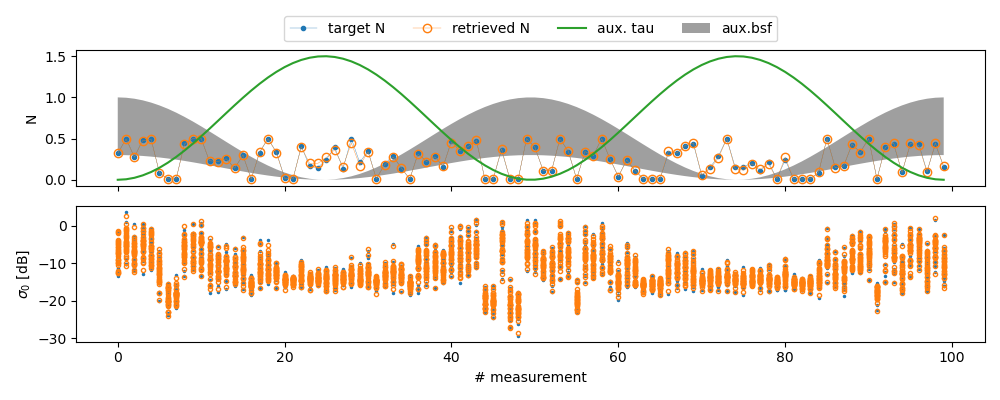

In [7]:
f, (ax, ax2) = plt.subplots(2, figsize=(10, 4), sharex=True)
f.canvas.header_visible = False

ax.set_ylabel("N")
ax2.set_ylabel(r"$\sigma_0$ [dB]")
ax2.set_xlabel("# measurement")

ax.plot(sim_params["N"], marker=".", lw=0.25, label="target N")
ax.plot(
    found_params["N"], marker="o", lw=0.25, markerfacecolor="none", label="retrieved N"
)

ax.plot(const_params["tau"], label="aux. tau")
ax.fill_between(range(num), const_params["bsf"].min(axis=1), const_params["bsf"].max(axis=1), alpha=0.5, label="aux.bsf", fc=".25")


ax2.plot(tot, lw=0, marker=".", c="C0", ms=3)
ax2.plot(found_tot, lw=0, marker="o", markerfacecolor="none", c="C1", ms=3)

ax.legend(loc="upper center", ncols=4, bbox_to_anchor=(0.5, 1.3))
f.tight_layout()

### Initialize analyzer widget and overlay results

21:13:47.086 INFO: Evaluating coefficients for interaction-term...
21:13:47.119 INFO: Coefficients extracted, it took 0.00704 sec.


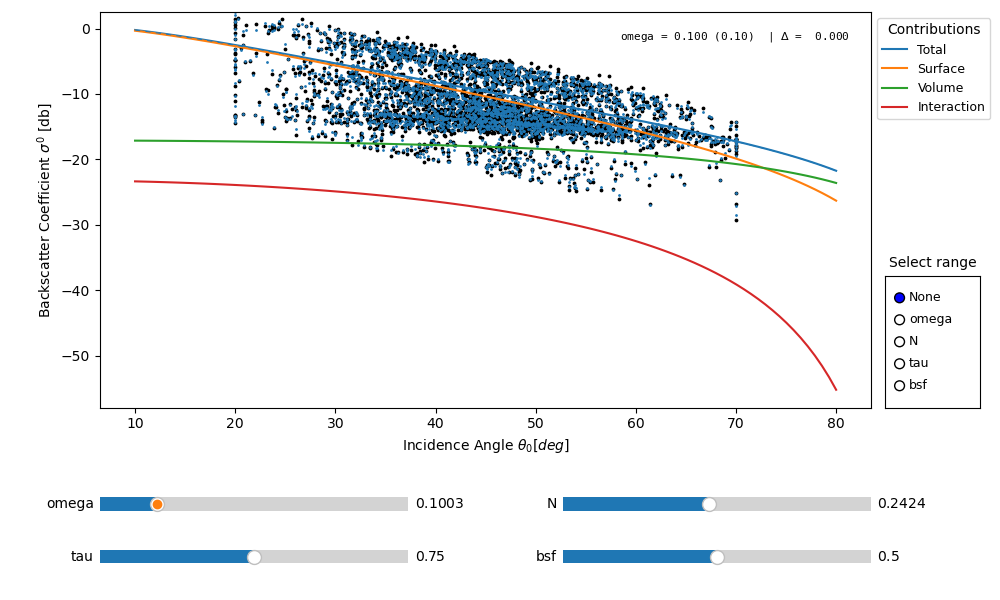

In [8]:
analyze_params = {key: (0.01, 0.5, found_params[key].mean()) for key in param_names}
# override aux. timeseries inputs so we can analyze a single observation
analyze_params["tau"] = (const_params["tau"].min(), const_params["tau"].max())
analyze_params["bsf"] = (const_params["bsf"].min(), const_params["bsf"].max())

ana = R.analyze(**analyze_params)

# Plot fit-data on top
ana.ax.scatter(inc, tot, c="k", s=3, zorder=0)
ana.ax.scatter(inc, found_tot, c="C0", s=1, zorder=0)

# Indicate fit-results in slider-axes
for key, s in ana.sliders.items():
    if key in ["omega"]:
        s.ax.plot(sim_params[key], np.mean(s.ax.get_ylim()), marker="o")

# Add text for static parameters
t = ana.f.text(
    0.6,
    0.95,
    "\n".join(
        [
            f"{key:>8} = {found_params[key]:.3f} ({sim_params[key]:.2f})  "
            rf"| $\Delta$ = {found_params[key] - sim_params[key]: .3f}"
            for key in ["omega"]
        ]
    ),
    va="top",
    fontdict=dict(family="monospace", size=8),
)